# Q1

## 问题分析

> **问题1**  对经中路-纬中路交叉口，根据**车流量的差异**，可**将一天分成若干个时段**，估计**不同时段各个相位**（包括四个方向直行、转弯）车流量。

对经中路-纬中路交叉口：数据筛选

分为四个相位：需要追踪车牌的流向

分为工作日与非工作日：拆分讨论

每天分为若干时段：聚类

分别估计车流量：根据经验数据估计正常值

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## 数据准备

读取数据

一定要使用encoding='gbk'，否则会报错。

In [7]:
original_data = pd.read_csv(r'D:\college\MCM\24\E\Attatchment2.csv', encoding='gbk')
original_data

,方向,时间,车牌号,交叉口
0,3,2024-04-03T14:39:08.632,AF5B7CEM,环西路-纬中路
1,1,2024-04-03T17:45:32.316,BK2IA84,环西路-纬中路
2,3,2024-04-03T15:09:04.087,AF4EC7FK,环西路-纬中路
3,2,2024-04-03T11:49:03.665,AF4MBB6,环西路-纬中路
4,3,2024-04-01T11:47:49.391,CBA7KCG,环西路-纬中路
...,...,...,...,...
8844991,2,2024-05-06T19:03:30.000,无车牌,经中路-环南路
8844992,1,2024-05-04T12:21:28.000,无车牌,经中路-环南路
8844993,1,2024-05-06T16:55:47.000,无车牌,经中路-环南路
8844994,2,2024-05-06T07:30:43.000,无车牌,经中路-环南路


## 工作日与非工作日有较大区别，需要分别考虑

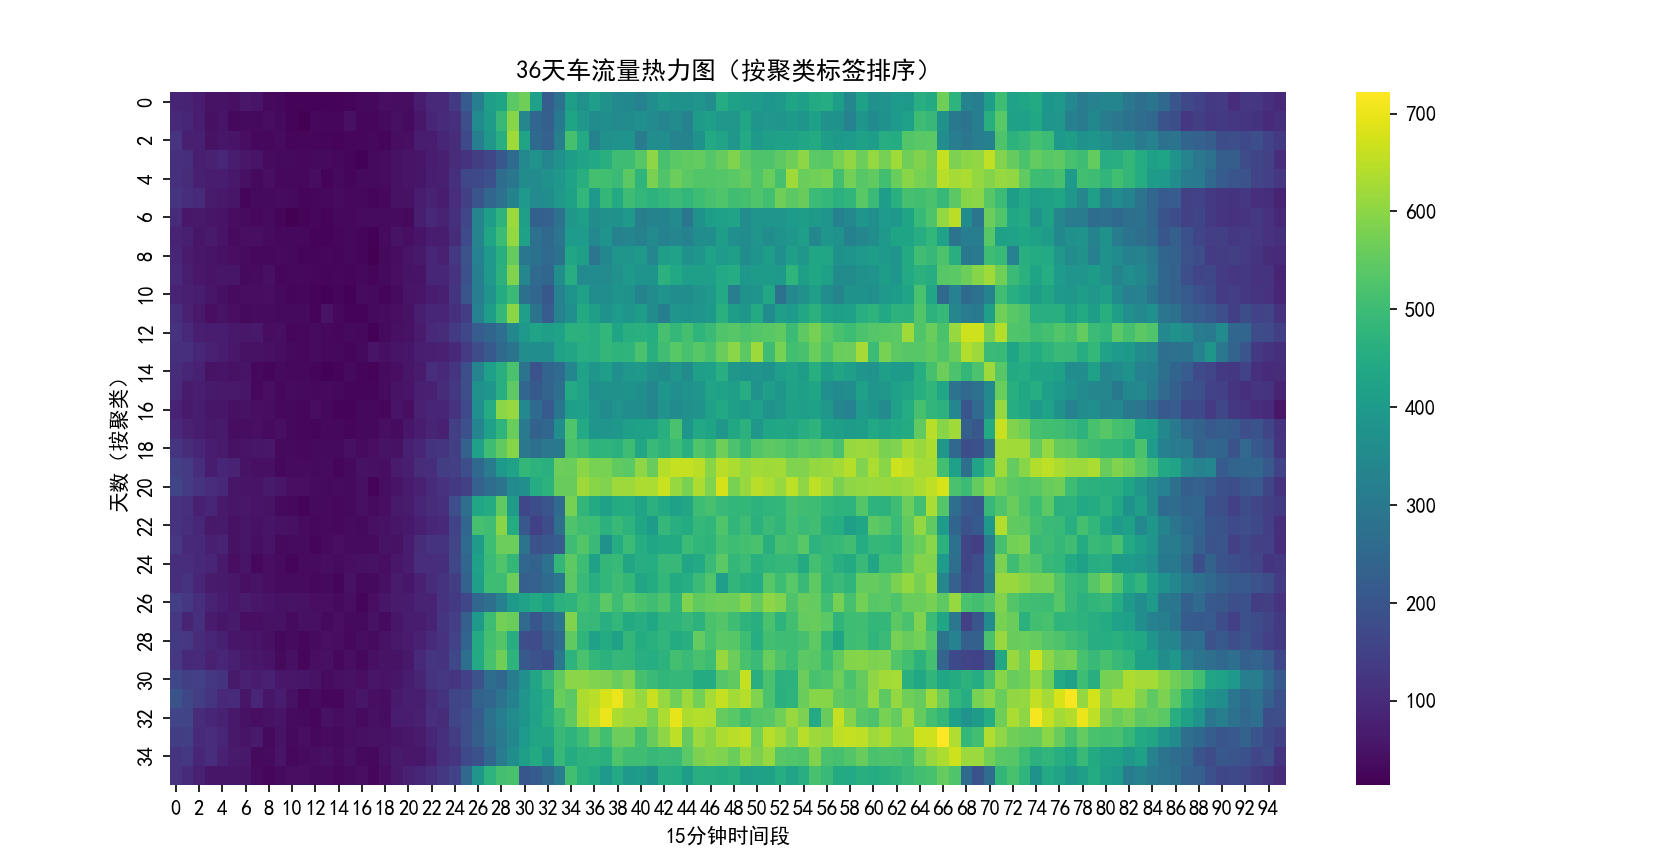

In [8]:
original_data["时间"] = pd.to_datetime(original_data["时间"])
original_data["Hour"] = original_data["时间"].dt.hour
original_data["DayofWeek"] = original_data["时间"].dt.dayofweek
original_data['Month'] = original_data['时间'].dt.month
original_data

,方向,时间,车牌号,交叉口,Hour,DayofWeek,Month
0,3,2024-04-03 14:39:08.632,AF5B7CEM,环西路-纬中路,14,2,4
1,1,2024-04-03 17:45:32.316,BK2IA84,环西路-纬中路,17,2,4
2,3,2024-04-03 15:09:04.087,AF4EC7FK,环西路-纬中路,15,2,4
3,2,2024-04-03 11:49:03.665,AF4MBB6,环西路-纬中路,11,2,4
4,3,2024-04-01 11:47:49.391,CBA7KCG,环西路-纬中路,11,0,4
...,...,...,...,...,...,...,...
8844991,2,2024-05-06 19:03:30.000,无车牌,经中路-环南路,19,0,5
8844992,1,2024-05-04 12:21:28.000,无车牌,经中路-环南路,12,5,5
8844993,1,2024-05-06 16:55:47.000,无车牌,经中路-环南路,16,0,5
8844994,2,2024-05-06 07:30:43.000,无车牌,经中路-环南路,7,0,5


In [ ]:
# 2. 筛选时间范围
mask = (original_data["时间"] >= "2024-04-01") & (original_data["时间"] <= "2024-05-06")
data_period = original_data.loc[mask].copy()

# 3. 定义2024年清明、五一假期和调休补班日
holidays = [
    "2024-04-04", "2024-04-05", "2024-04-06",  # 清明节
    "2024-05-01", "2024-05-02", "2024-05-03", "2024-05-04", "2024-05-05"  # 五一
]
extra_workdays = [
    "2024-04-07", "2024-04-28", "2024-05-11"  # 调休补班日
]

# 4. 新建日期列
data_period["Date"] = data_period["时间"].dt.date.astype(str)

# 5. 判断是否为假期或调休工作日
is_holiday = data_period["Date"].isin(holidays)
is_extra_workday = data_period["Date"].isin(extra_workdays)
is_weekend = data_period["时间"].dt.dayofweek >= 5  # 周六日

# 6. 工作日条件：不是周末且不是法定假日，或调休补班日
workday_mask = ((~is_weekend) & (~is_holiday)) | is_extra_workday
workdays = data_period.loc[workday_mask].copy()

# 7. 非工作日条件：周末或法定假日，且不是调休补班日
nonworkday_mask = (is_weekend | is_holiday) & (~is_extra_workday)
nonworkdays = data_period.loc[nonworkday_mask].copy()

# 8. 结果
# print("工作日样例：")
# print(workdays)
# print("非工作日样例：")
# print(nonworkdays)

工作日样例：
         方向                      时间       车牌号      交叉口  Hour  DayofWeek  \
0         3 2024-04-03 14:39:08.632  AF5B7CEM  环西路-纬中路    14          2   
1         1 2024-04-03 17:45:32.316   BK2IA84  环西路-纬中路    17          2   
2         3 2024-04-03 15:09:04.087  AF4EC7FK  环西路-纬中路    15          2   
3         2 2024-04-03 11:49:03.665   AF4MBB6  环西路-纬中路    11          2   
4         3 2024-04-01 11:47:49.391   CBA7KCG  环西路-纬中路    11          0   
...      ..                     ...       ...      ...   ...        ...   
8842869   1 2024-04-30 07:54:25.000       无车牌  经中路-环南路     7          1   
8842870   1 2024-04-29 05:08:13.000       无车牌  经中路-环南路     5          0   
8842871   1 2024-04-30 13:21:40.000       无车牌  经中路-环南路    13          1   
8842872   1 2024-04-29 01:30:40.000       无车牌  经中路-环南路     1          0   
8842873   2 2024-04-29 11:50:01.000       无车牌  经中路-环南路    11          0   

         Month        Date  
0            4  2024-04-03  
1            4  2024-04-03  
2    

In [10]:
workdays

,方向,时间,车牌号,交叉口,Hour,DayofWeek,Month,Date
0,3,2024-04-03 14:39:08.632,AF5B7CEM,环西路-纬中路,14,2,4,2024-04-03
1,1,2024-04-03 17:45:32.316,BK2IA84,环西路-纬中路,17,2,4,2024-04-03
2,3,2024-04-03 15:09:04.087,AF4EC7FK,环西路-纬中路,15,2,4,2024-04-03
3,2,2024-04-03 11:49:03.665,AF4MBB6,环西路-纬中路,11,2,4,2024-04-03
4,3,2024-04-01 11:47:49.391,CBA7KCG,环西路-纬中路,11,0,4,2024-04-01
...,...,...,...,...,...,...,...,...
8842869,1,2024-04-30 07:54:25.000,无车牌,经中路-环南路,7,1,4,2024-04-30
8842870,1,2024-04-29 05:08:13.000,无车牌,经中路-环南路,5,0,4,2024-04-29
8842871,1,2024-04-30 13:21:40.000,无车牌,经中路-环南路,13,1,4,2024-04-30
8842872,1,2024-04-29 01:30:40.000,无车牌,经中路-环南路,1,0,4,2024-04-29


## 根据交叉口和方向分组

grouped 的键是 (交叉口, 方向) 的元组，值是对应的小表格

In [ ]:
grouped = dict(tuple(original_data.groupby(['交叉口', '方向'])))

print(grouped.keys())

# 例如，查看“环西路-纬中路”交叉口，“东”方向的数据
grouped[('环西路-纬中路', 1)]  #这玩意的类型是DataFrame

dict_keys([('环东路-纬中路', np.int64(1)), ('环东路-纬中路', np.int64(2)), ('环东路-纬中路', np.int64(3)), ('环东路-纬中路', np.int64(4)), ('环西路-纬中路', np.int64(1)), ('环西路-纬中路', np.int64(2)), ('环西路-纬中路', np.int64(3)), ('环西路-纬中路', np.int64(4)), ('纬中路-景区出入口', np.int64(1)), ('纬中路-景区出入口', np.int64(2)), ('纬中路-景区出入口', np.int64(3)), ('纬中路-景区出入口', np.int64(4)), ('经一路-纬中路', np.int64(1)), ('经一路-纬中路', np.int64(2)), ('经一路-纬中路', np.int64(3)), ('经一路-纬中路', np.int64(4)), ('经三路-纬中路', np.int64(1)), ('经三路-纬中路', np.int64(2)), ('经三路-纬中路', np.int64(3)), ('经三路-纬中路', np.int64(4)), ('经中路-环北路', np.int64(1)), ('经中路-环北路', np.int64(2)), ('经中路-环北路', np.int64(3)), ('经中路-环北路', np.int64(4)), ('经中路-环南路', np.int64(1)), ('经中路-环南路', np.int64(2)), ('经中路-环南路', np.int64(3)), ('经中路-环南路', np.int64(4)), ('经中路-纬一路', np.int64(1)), ('经中路-纬一路', np.int64(2)), ('经中路-纬一路', np.int64(3)), ('经中路-纬一路', np.int64(4)), ('经中路-纬中路', np.int64(1)), ('经中路-纬中路', np.int64(2)), ('经中路-纬中路', np.int64(3)), ('经中路-纬中路', np.int64(4)), ('经二路-纬中路', np.int64(1)), ('经二路-纬中路', np.int6

pandas.core.frame.DataFrame

## 数据筛选

In [ ]:
xmid_ymid = original_data.loc[original_data["交叉口"]=="经中路-纬中路" ,:].copy()
xmid_ymid.loc[:,'时间'] = pd.to_datetime(xmid_ymid.loc[:,'时间'])
xmid_ymid = xmid_ymid.set_index('时间')
xmid_ymid #筛选出经中路-纬中路的数据，将时间自动转换为datetime类型，并作为索引

d:\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,方向,车牌号,交叉口
时间,,,
2024-04-03 13:47:18,4,AF45D87,经中路-纬中路
2024-04-01 21:16:31,4,AFXBA37,经中路-纬中路
2024-04-01 21:14:07,4,EF8U5E0,经中路-纬中路
2024-04-01 10:12:40,4,AB3F68FK,经中路-纬中路
2024-04-01 09:17:32,4,AF2U9DD,经中路-纬中路
...,...,...,...
2024-05-06 00:21:18,4,无车牌,经中路-纬中路
2024-05-05 23:45:38,4,无车牌,经中路-纬中路
2024-05-05 22:54:12,4,无车牌,经中路-纬中路


In [ ]:
for i in range(1,23):
    

,方向,车牌号,交叉口
时间,,,
2024-04-03 13:47:18,4,AF45D87,经中路-纬中路
2024-04-01 21:16:31,4,AFXBA37,经中路-纬中路
2024-04-01 21:14:07,4,EF8U5E0,经中路-纬中路
2024-04-01 10:12:40,4,AB3F68FK,经中路-纬中路
2024-04-01 09:17:32,4,AF2U9DD,经中路-纬中路
...,...,...,...
2024-04-29 10:59:57,1,无车牌,经中路-纬中路
2024-04-30 12:14:50,4,无车牌,经中路-纬中路
2024-04-30 19:00:14,1,无车牌,经中路-纬中路


In [31]:
# 1. 筛选交叉口
xmid_ymid = original_data.loc[original_data["交叉口"] == "经中路-纬中路", :].copy()

# 2. 时间转为datetime，并提取小时
xmid_ymid["时间"] = pd.to_datetime(xmid_ymid["时间"])
xmid_ymid["小时"] = xmid_ymid["时间"].dt.hour

result = xmid_ymid.groupby(["方向", "小时"]).size().reset_index(name='计数')
# 4. 显示结果
result

,方向,小时,计数
0,1,0,4449
1,1,1,2468
2,1,2,1674
3,1,3,1011
4,1,4,1054
...,...,...,...
91,4,19,22935
92,4,20,21840
93,4,21,16385
94,4,22,10758


d:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36710 (\N{CJK UNIFIED IDEOGRAPH-8F66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEOGRAPH-6D41}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32463 (\N{CJK UNIFIED IDEOGRAPH-7ECF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\Li

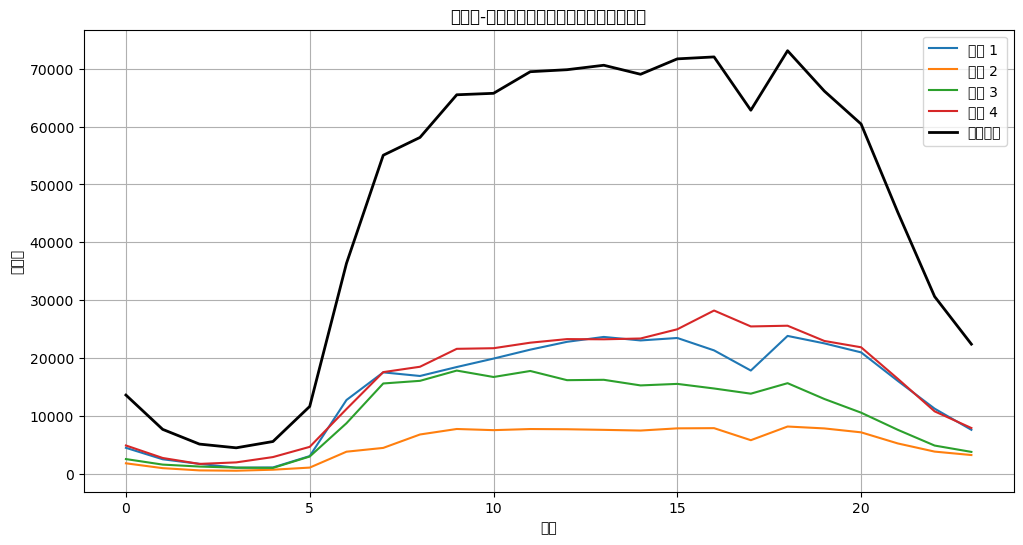

In [ ]:
# 1. 按方向和小时统计车流量（这里用计数，如果有“流量”列可用sum）
result = xmid_ymid.groupby(["方向", "小时"]).size().reset_index(name='计数')

# 2. 透视表，方便画图
pivot = result.pivot(index='小时', columns='方向', values='计数')

# 3. 计算每小时总车流量
pivot['总车流量'] = pivot.sum(axis=1)

# 4. 绘图
plt.figure(figsize=(12,6))
for direction in pivot.columns[:-1]:  # 不包括总车流量
    plt.plot(pivot.index, pivot[direction], label=f'方向 {direction}')
plt.plot(pivot.index, pivot['总车流量'], label='总车流量', linewidth=2, color='black')

plt.xlabel('小时')
plt.ylabel('车流量')
plt.title('经中路-纬中路各方向及总车流量逐小时变化')
plt.legend()
plt.grid(True)
plt.show()